<font size="18"> Testing audio feature extraction - MFCC </font>

Example from Pytorch

In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

1.13.1+cu116
0.13.1+cu116


In [2]:
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset
torch.random.manual_seed(0)

SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)

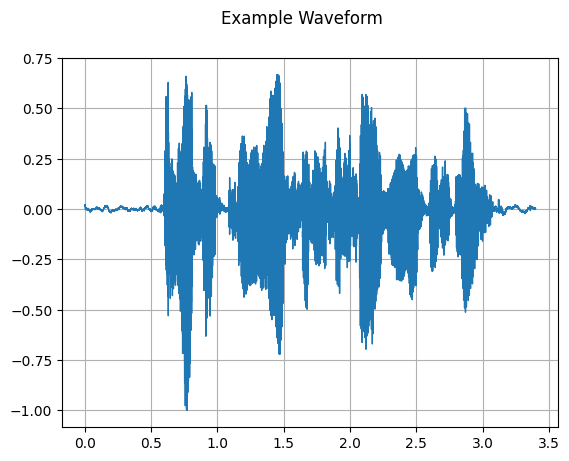

In [3]:
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)

plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Example Waveform")
Audio(SPEECH_WAVEFORM.numpy(), rate=SAMPLE_RATE)

In [4]:
# MFCC
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256
sample_rate = 6000

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(SPEECH_WAVEFORM)

In [5]:
mfcc

tensor([[[-4.9580e+02, -4.9482e+02, -4.9612e+02,  ..., -4.2226e+02,
          -4.0157e+02, -4.3528e+02],
         [ 7.6858e+01,  8.2947e+01,  8.2908e+01,  ...,  1.0710e+02,
           1.2769e+02,  1.1310e+02],
         [ 1.8454e+01,  2.2336e+01,  2.1795e+01,  ...,  2.4616e+01,
           1.8316e+01,  1.6142e+01],
         ...,
         [ 2.6870e+00,  2.9211e+00,  2.3788e+00,  ...,  1.9847e+00,
           1.8916e+00,  3.6914e-01],
         [ 4.1728e-01,  1.5918e+00,  8.6383e-01,  ..., -9.9495e-01,
          -9.3745e-01,  1.2627e+00],
         [-2.2189e+00, -1.6164e+00, -3.4868e-01,  ..., -2.1618e+00,
          -1.7864e+00,  7.8549e-01]]])

In [6]:
mfcc.size()

torch.Size([1, 256, 107])

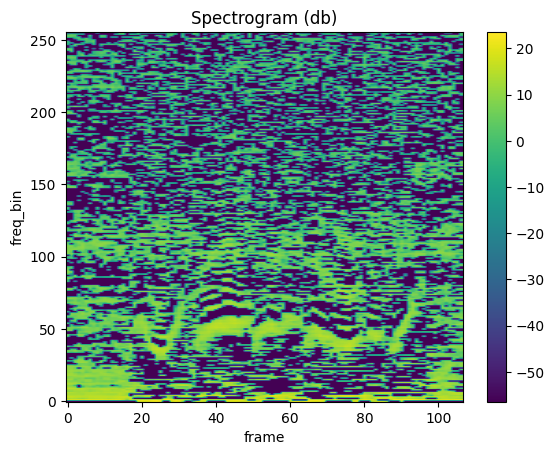

In [7]:
plot_spectrogram(mfcc[0])

<font size="6"> Data Processing Procedure</font>

1. Convert mp3 files to wav files

In [8]:
import os
from pydub import AudioSegment

directory = "../train_data"

for filename in os.listdir(directory):
    output_filename = "wav_training_data/" + filename[:-3] + "wav"
    if not os.path.exists(output_filename):
        sound = AudioSegment.from_mp3("../train_data/" + filename)
        sound.export(output_filename, format="wav")

Separate data into training and testing

In [8]:
import pandas as pd
import shutil

test_df = pd.read_csv("test_files.csv")

In [7]:
test_fN = test_df['path'].to_numpy()

In [10]:
for filename in test_fN:
    new_path = "test_data/" + filename[:-3] + "wav"
    old_path = "wav_training_data/" + filename[:-3] + "wav"
    shutil.move(old_path, new_path)

2. Create custom dataset class

In [1]:
# imports
import os
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
# define MFCC transformation
n_fft = 2048
win_length = None
hop_length = 256
n_mels = 128
n_mfcc = 128
sample_rate = 6000

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

In [3]:
class AudioFileDataset(Dataset):
    def __init__(self, annotations_file, audio_dir, transform=mfcc_transform, target_transform=None):
        self.audio_labels = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.audio_labels)
    
    def __getitem__(self, idx):
        # get path to audio file
        filename = self.audio_labels.iloc[idx, 0][:-3] + "wav"
        audio_path = os.path.join(self.audio_dir, filename)
        
        # load audio file
        speech_waveform, sample_rate = torchaudio.load(audio_path)
        
        # get associated label for audio_path
        label = self.audio_labels.iloc[idx, 1]
        
        # transform mfcc if there is a transform
        if self.transform:
            mfcc = self.transform(speech_waveform)
        if self.target_transform:
            label = self.target_transform(label)
        return mfcc[:,:,:128], label


3. Visualize Data

In [4]:
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset
torch.random.manual_seed(0)

# def plot_waveform(waveform, sr, title="Waveform"):
#     waveform = waveform.numpy()
#     num_channels, num_frames = waveform.shape
#     time_axis = torch.arange(0, num_frames) / sr

#     figure, axes = plt.subplots(num_channels, 1)
#     axes.plot(time_axis, waveform[0], linewidth=1)
#     axes.grid(True)
#     figure.suptitle(title)
#     plt.show(block=False)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [6]:
training_data = AudioFileDataset("train_files.csv", "wav_training_data")

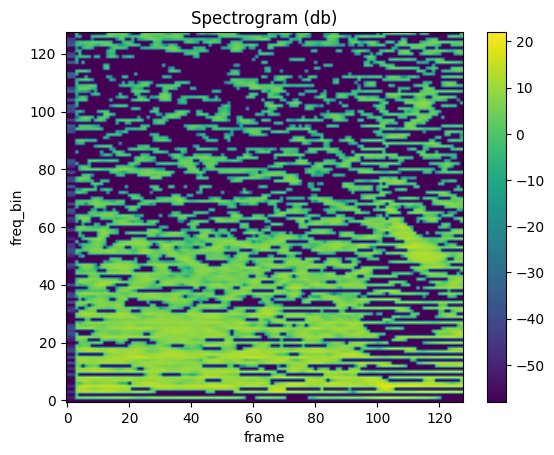

MFCC size: torch.Size([1, 128, 128])


In [7]:
mfcc_tensor = training_data.__getitem__(3)[0]
plot_spectrogram(mfcc_tensor[0])
print(f"MFCC size: {mfcc_tensor.size()}")

4. Iterate through DataLoader

In [8]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
mfcc_tensor = train_features[0].__getitem__(0)
label = train_labels[0]
plot_spectrogram(mfcc_tensor)
print(f"Label: {label}")

5. Test training

In [ ]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(128*128, 8192),
            nn.ReLU(),
            nn.Linear(8192, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork()

In [ ]:
learning_rate = 1e-3
batch_size = 64

# initialize loss function
loss_fn = nn.CrossEntropyLoss()

# initialize optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 100 == 0:
        loss, current = loss.item(), (batch + 1) * len(X)
        print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
print("Done!")